In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [84]:
# 関数の定義

def process_data(X):
    """
    is_holiday : 祝日かを表すフラグ
    """
    X['is_holiday'] = ~X['description'].isna()
    X = X.drop(columns=['holiday_date', 'description'])
    
    
    """
    'match_date' と 'kick_off_time' から、'year' 'month' 'day' 'kick_off_time' を作成
    元の 'match_date' と 'kick_off_time' 列は削除。
    """
    X['match_date'] = pd.to_datetime(X['match_date'])
    X['year'] = X['match_date'].dt.year
    X['month'] = X['match_date'].dt.month
    X['day'] = X['match_date'].dt.day
    X['weekday'] = X['match_date'].dt.day_name()
    X['kick_off_hour'] = X['kick_off_time'].str.split(':').str[0].astype(int)
    X = X.drop(['match_date', 'kick_off_time'], axis=1)
    
    
    """
    天気
    晴・曇・雨の他に、晴れのち雨とかが多すぎる
    晴のち雨は雨
    """
    
    X['weather'] = X['weather'].apply(lambda x: '悪天候' if any(y in x for y in ['雨', '雪', '霧']) else ('曇' if '曇' in x else x))
    
    
    """
    
    """
    X['broadcasters_count'] = X['broadcasters'].apply(lambda x: len(x.split('/')))
    X['main_broadcaster'] = X['broadcasters'].apply(lambda x: x.split('/')[0])
    
    
    return X


In [85]:
# データセットの読み込み
train_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')
venue_information = pd.read_csv('datasets/venue_information.csv')
match_reports = pd.read_csv('datasets/match_reports.csv')
holidays_in_japan = pd.read_csv('datasets/holidays_in_japan.csv')

# データの前処理
train_data = pd.merge(train_data, venue_information, on='venue', how="inner", validate="many_to_many")
train_data = pd.merge(train_data, holidays_in_japan, left_on='match_date', right_on='holiday_date', how="left", validate="many_to_many")
train_data = process_data(train_data)
train_data['attendance_rate'] = train_data['attendance'] / train_data['capacity']


test_data = pd.merge(test_data, venue_information, on='venue', how="inner", validate="many_to_many")
test_data = pd.merge(test_data, holidays_in_japan, left_on='match_date', right_on='holiday_date', how="left", validate="many_to_many")
test_data = process_data(test_data)


In [86]:
# 使用しない特徴量
ignore_features = ['id', 'year', 'round', 'broadcasters', 'attendance', 'attendance_rate']

# 特徴量を分類
categorical_features = []
numeric_features = []

for f in list(train_data.columns):
    if f in ignore_features:
        continue
    if train_data[f].dtype in ['object', 'bool']:
        categorical_features.append(f)
    else:
        numeric_features.append(f)
        
features = numeric_features + categorical_features


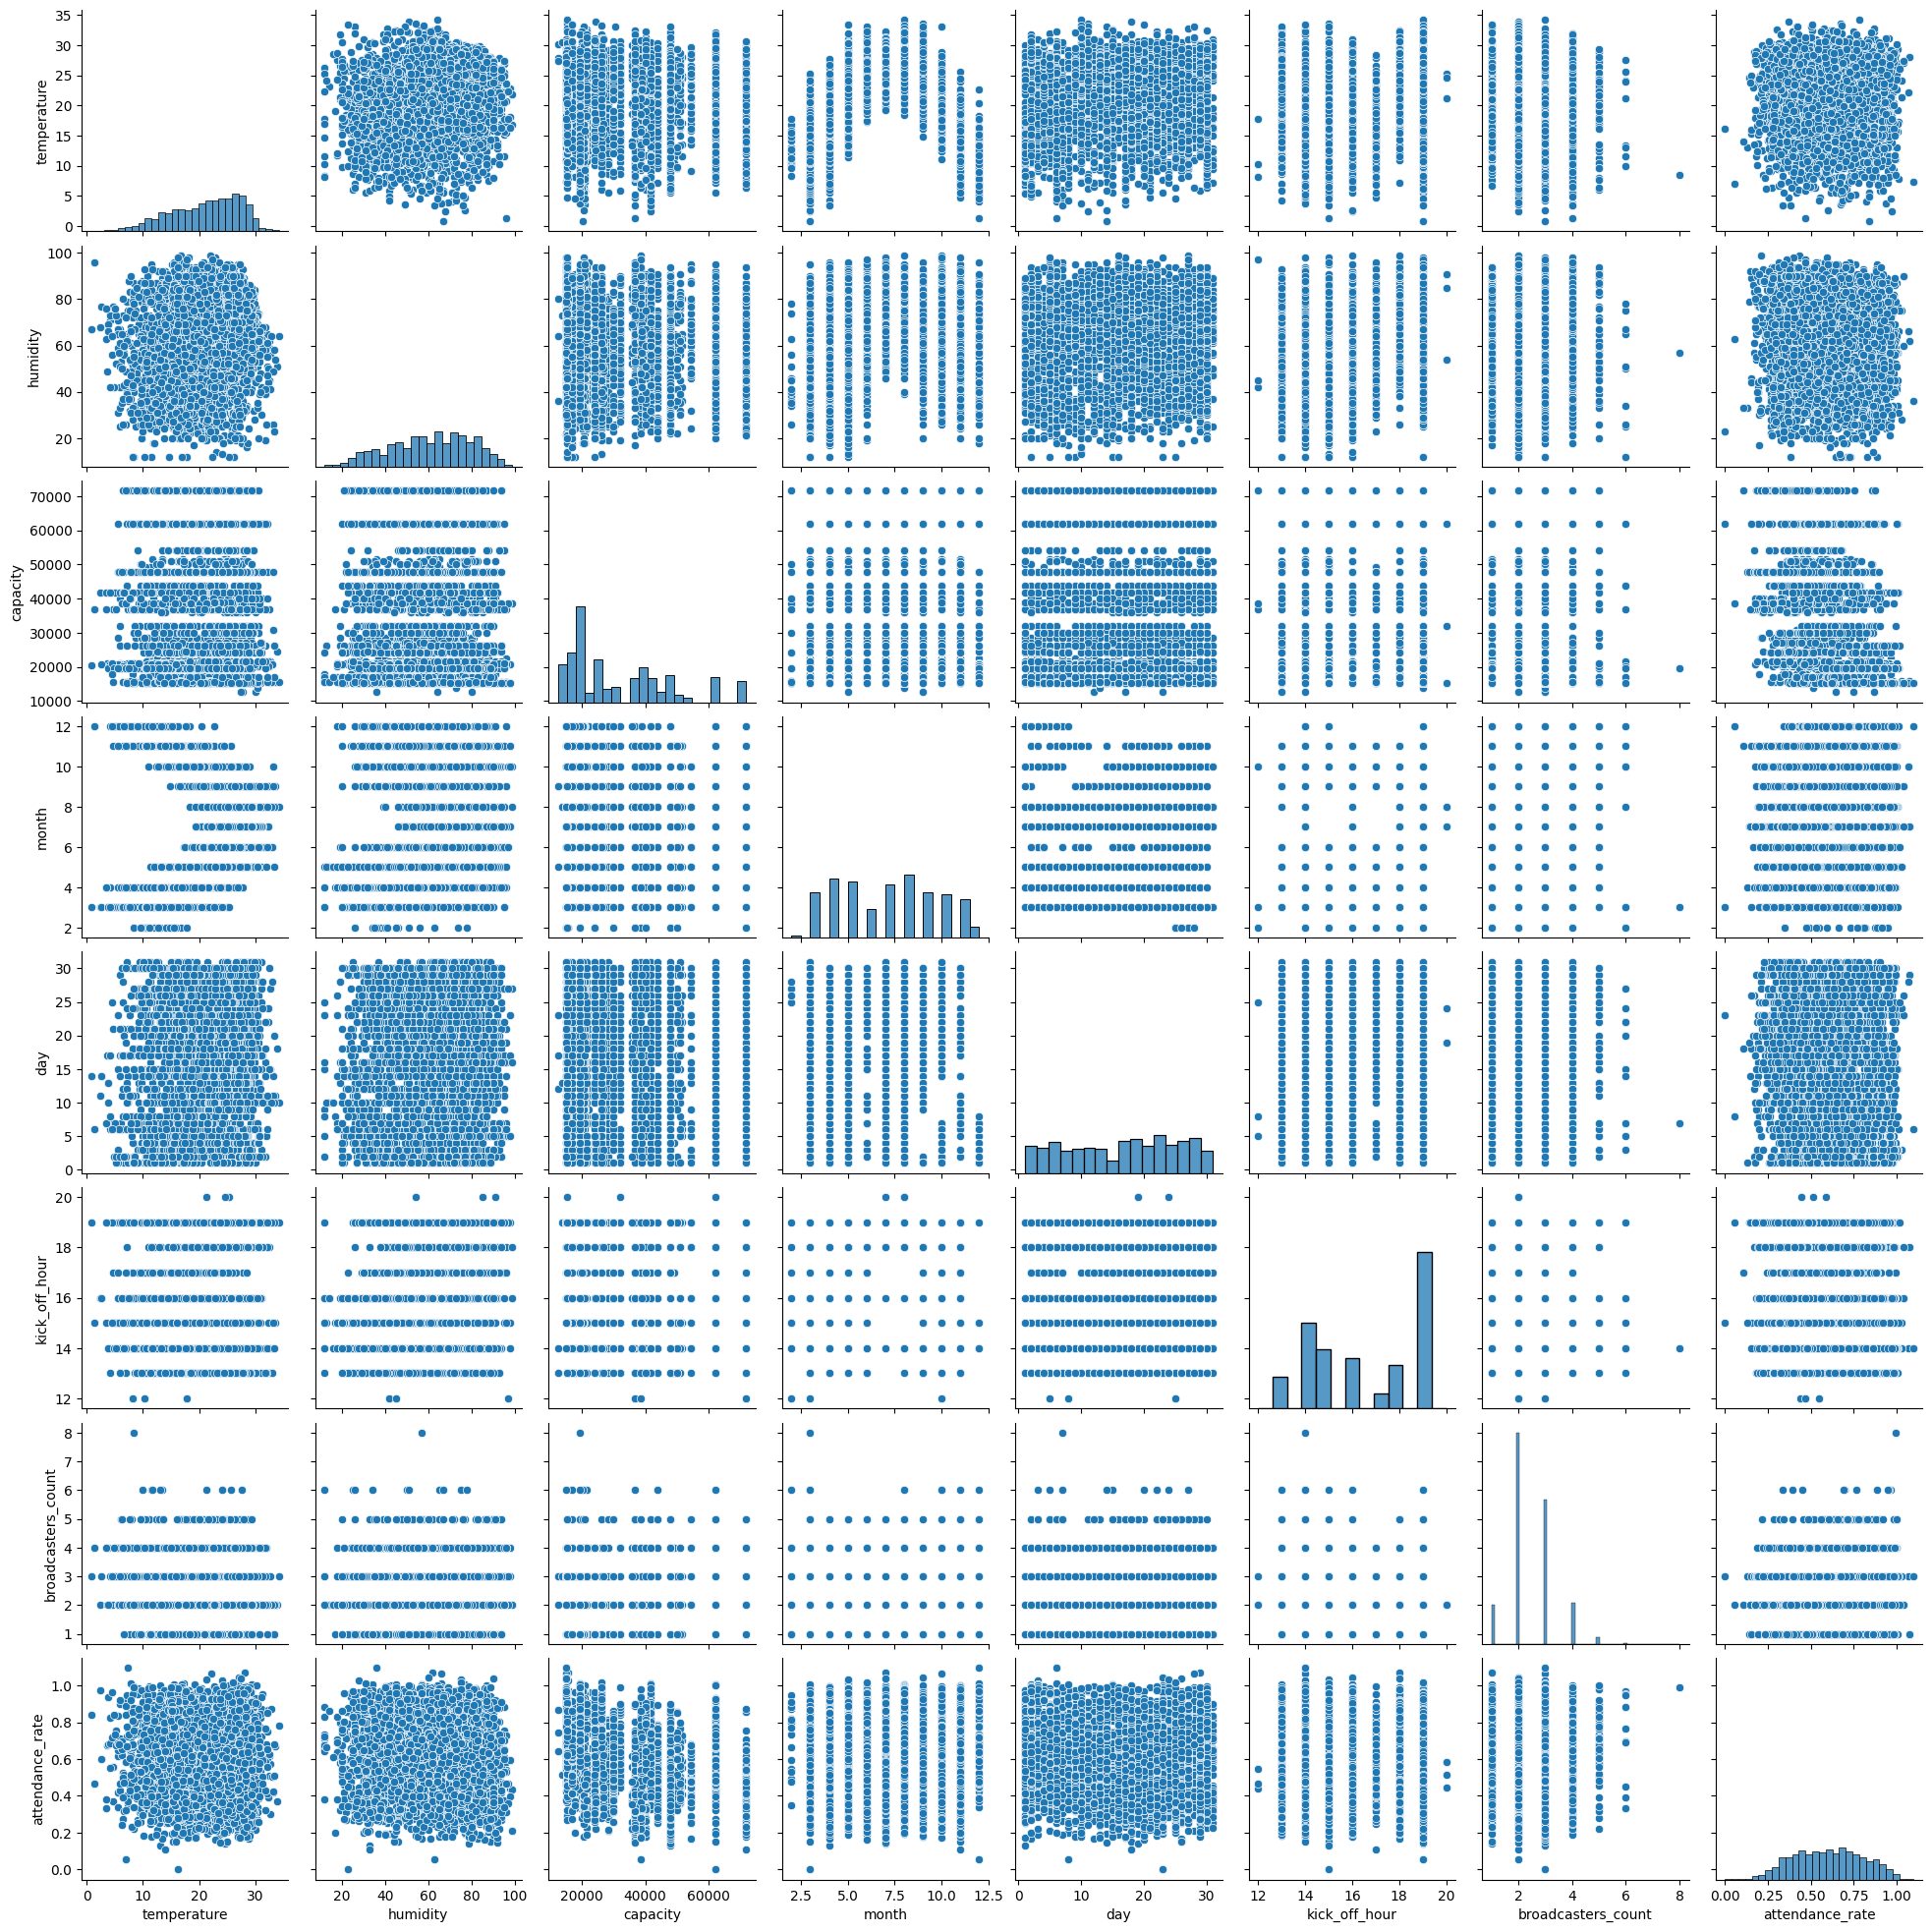

In [87]:
#変数同士の関係性を見てみる。
graph = sns.pairplot(train_data[numeric_features + ['attendance_rate']])

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31680 (\N{CJK UNIFIED IDEOGRAPH-7BC0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


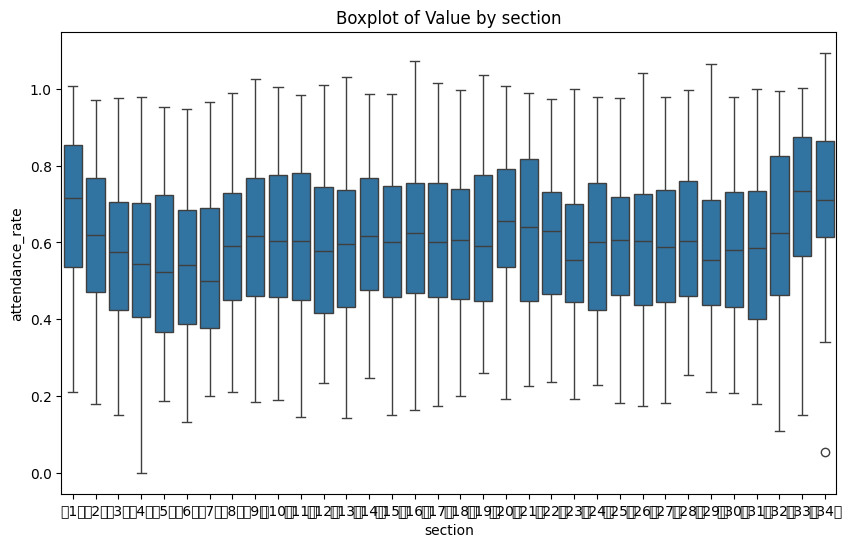

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38442 (\N{CJK UNIFIED IDEOGRAPH-962A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30002 (\N{CJK UNIFIED IDEOGRAPH-7532}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24220 (\N{CJK UNIFIED IDEOGRAPH-5E9C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

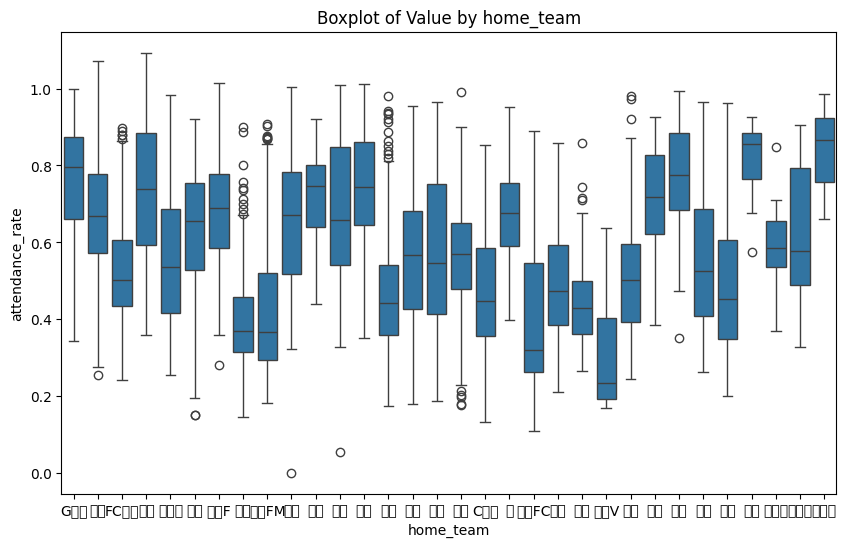

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28165 (\N{CJK UNIFIED IDEOGRAPH-6E05}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

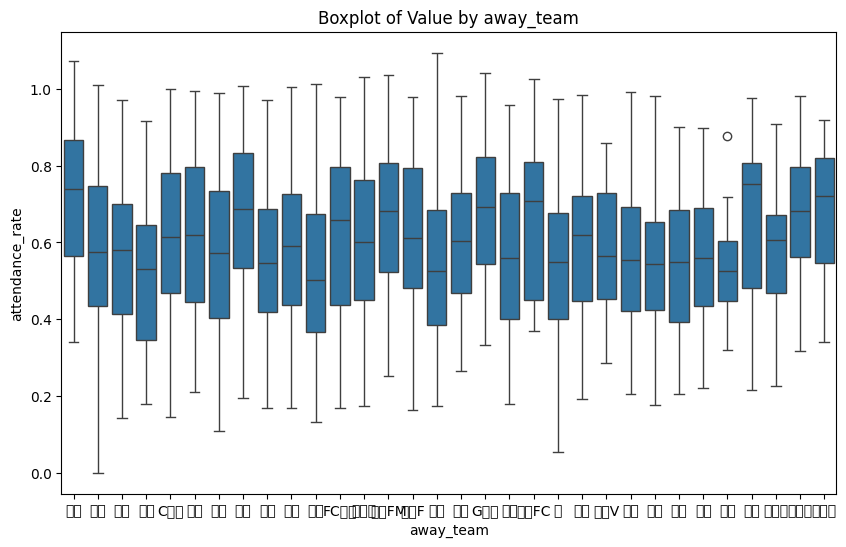

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21338 (\N{CJK UNIFIED IDEOGRAPH-535A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35352 (\N{CJK UNIFIED IDEOGRAPH-8A18}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24565 (\N{CJK UNIFIED IDEOGRAPH-5FF5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

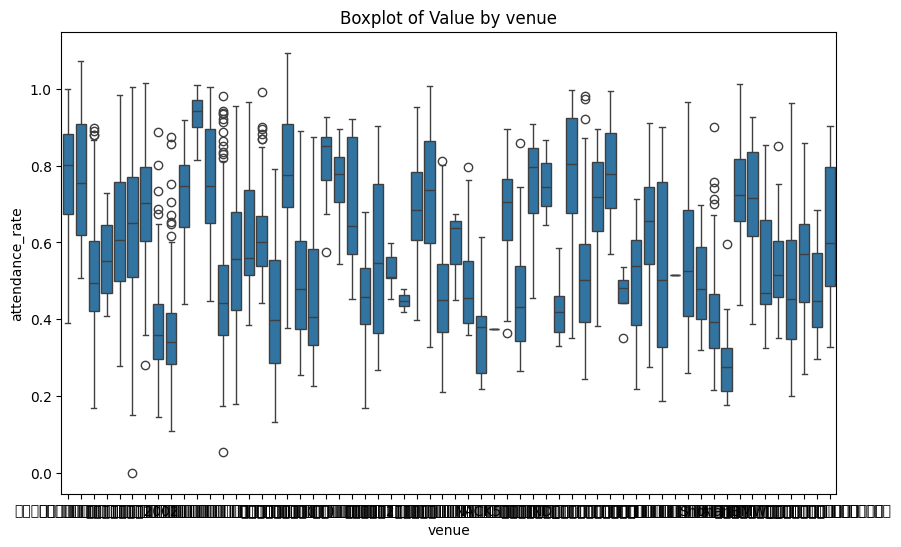

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26228 (\N{CJK UNIFIED IDEOGRAPH-6674}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26311 (\N{CJK UNIFIED IDEOGRAPH-66C7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23627 (\N{CJK UNIFIED IDEOGRAPH-5C4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

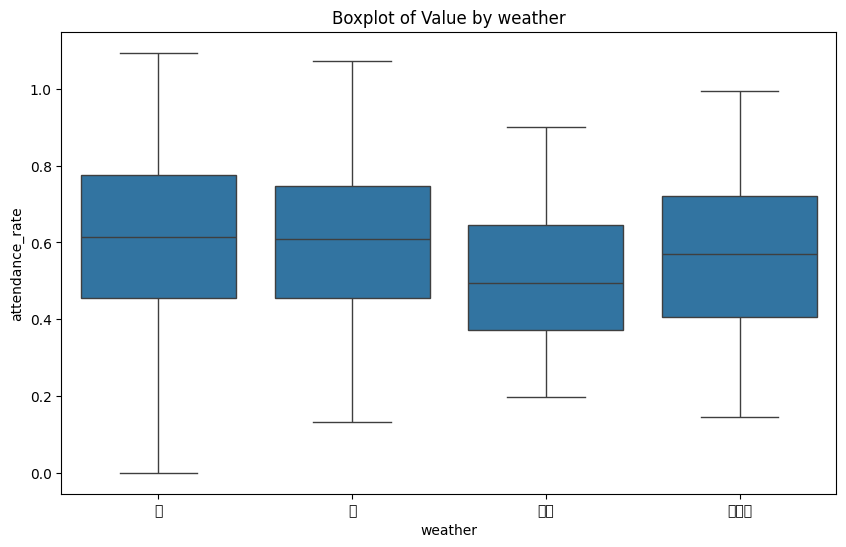

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38442 (\N{CJK UNIFIED IDEOGRAPH-962A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24220 (\N{CJK UNIFIED IDEOGRAPH-5E9C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21561 (\N{CJK UNIFIED IDEOGRAPH-5439}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

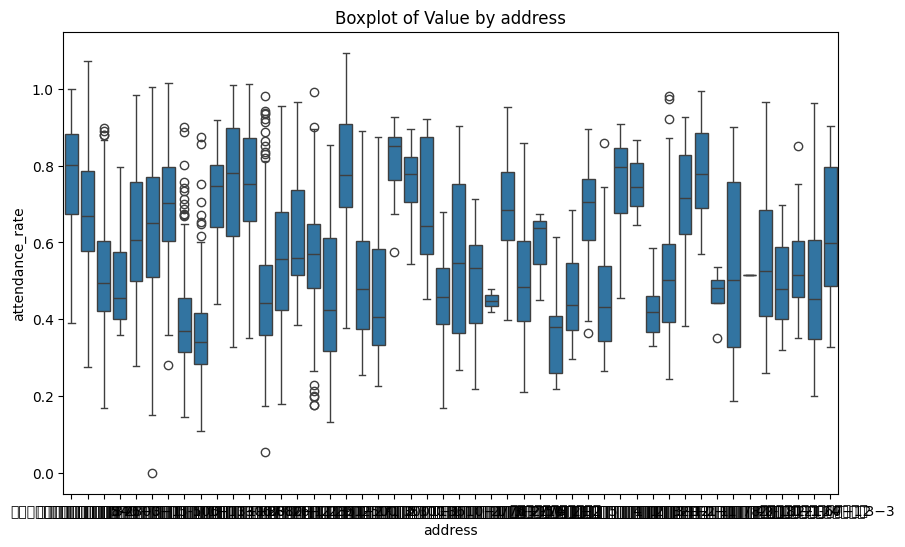

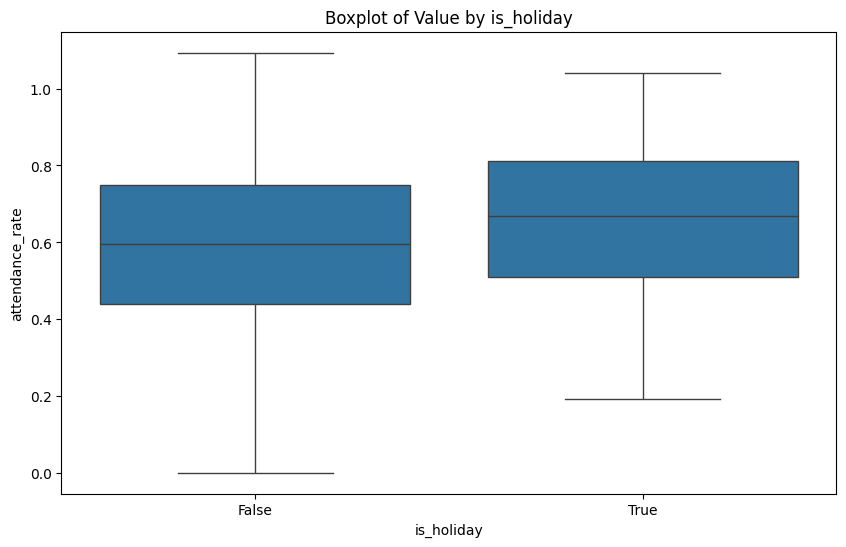

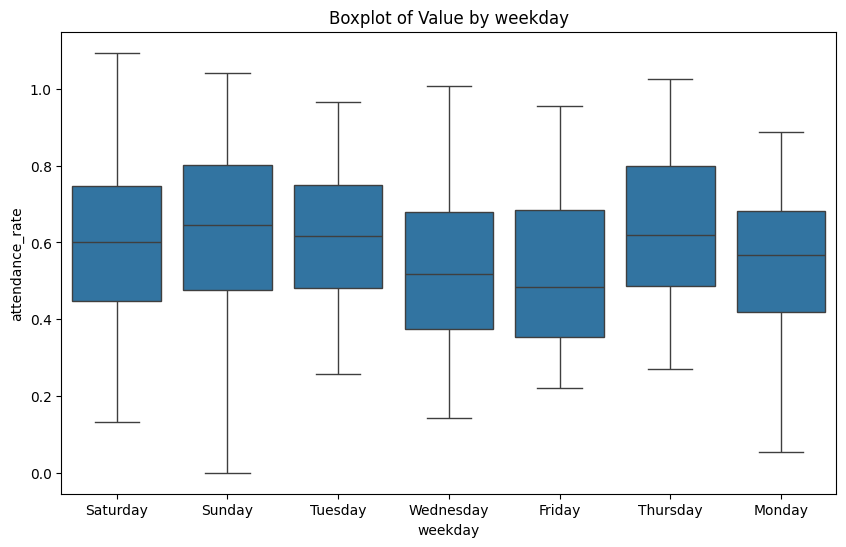

/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32207 (\N{CJK UNIFIED IDEOGRAPH-7DCF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Signate/.env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26792 (\N{CJK UNIFIED IDEOGRAPH-68A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/macbookairkouki/Developer/Sig

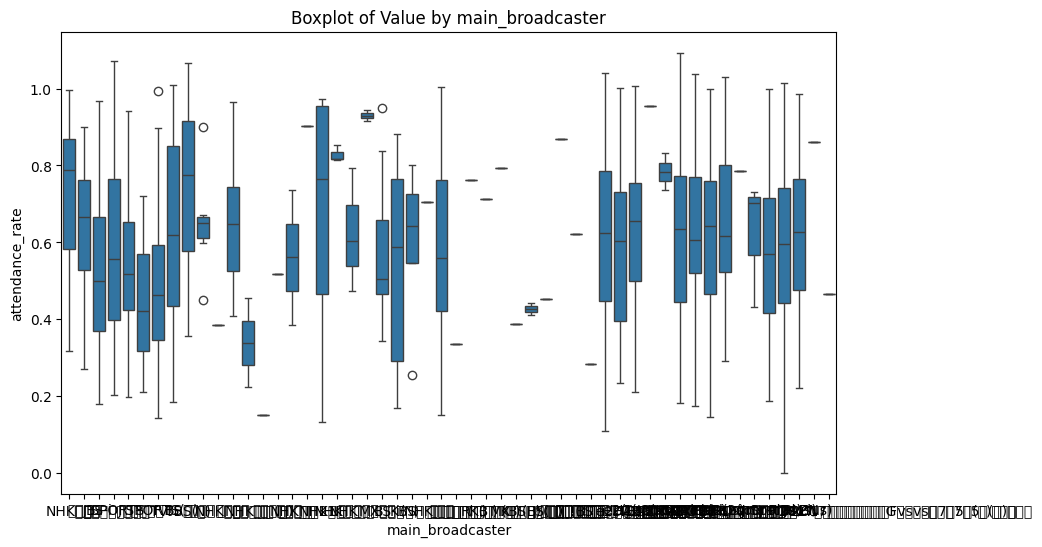

In [88]:
# ボックスプロットの描画
for c in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=c, y='attendance_rate', data=train_data)
    plt.title(f'Boxplot of Value by {c}')
    plt.show()